# Circular track manifold visualisation -- sim & real

In [2]:
import sys, os, time
import numpy as np
import scipy.io as io
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE
from sklearn.model_selection import KFold
import sklearn.metrics.pairwise as mtr

import umap
import warnings
warnings.filterwarnings("ignore")

In [3]:
def cmdscale(D):
    """                                                                                       
    Classical multidimensional scaling (MDS)                                                  

    Parameters                                                                                
    ----------                                                                                
    D : (n, n) array                                                                          
        Symmetric distance matrix.                                                            

    Returns                                                                                   
    -------                                                                                   
    Y : (n, p) array                                                                          
        Configuration matrix. Each column represents a dimension. Only the                    
        p dimensions corresponding to positive eigenvalues of B are returned.                 
        Note that each dimension is only determined up to an overall sign,                    
        corresponding to a reflection.                                                        

    e : (n,) array                                                                            
        Eigenvalues of B.                                                                     

    """
    # Number of points                                                                        
    n = len(D)
    # Centering matrix                                                                        
    H = np.eye(n) - np.ones((n, n))/n
    # YY^T                                                                                    
    B = -H.dot(D**2).dot(H)/2
    # Diagonalize                                                                             
    evals, evecs = np.linalg.eigh(B)
    # Sort by eigenvalue in descending order                                                  
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:,idx]
    # Compute the coordinates using positive-eigenvalued components only                      
    w, = np.where(evals>0)
    L = np.diag(np.sqrt(evals[w]))
    V = evecs[:,w]
    Y = V.dot(L)

    return Y, evals

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    """

    if window_len<3:
        return x

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

def OLE(X, Y):
    # Optimal linear estimator - obtain the estimator's weights
    X = np.c_[np.ones((X.shape[0], 1)), X]
    # obtain the estimator
    return np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, Y))

def LinRec(f, X, Y):
    # Obtain the prediction on the test data
    X = np.c_[np.ones((X.shape[0], 1)), X]  # append a row of ones to the input
    Rec = np.dot(X, f)
    # Evaluate the prediction
    RMSE = np.mean(np.sqrt((Y - Rec)**2))
    R = np.corrcoef(Y, Rec)[0, 1]
    return Rec, RMSE, R

def rec_embd_lle(M_embd, M, k, lam=1):
    # Adapted from https://github.com/jakevdp/pyLLE/blob/master/pyLLE/python_only/LLE.py
    """
    inputs:
       - M: a rank [d * N] data-matrix
       - M_embd: a rank [m * N] matrix which is the output of LLE(M,k,m)
       - k: the number of neighbors to use for the reconstruction
       - lam = regularisation parameter
    returns:
       - y: the LLE reconstruction of x
    """
    # make sure inputs are of the right dimansions and convert to np.matrix
    M = np.matrix(M)
    M_embd = np.matrix(M_embd)
    d,N = M.shape
    m,N2 = M_embd.shape
    assert N==N2    

    # initialise matrix to store eigenvalues
    min_dim = np.min([m,k])
    eig = np.zeros((N,min_dim))
    W = np.matrix(np.zeros((N,N)))

    for i in range(M.shape[1]):
        # find k nearest neighbors
        M_xi = np.array(M_embd - M_embd[:,i])
        vec = (M_xi**2).sum(0)
        nbrs = np.argsort(vec)[1:k+1] # exclude self-neighbour
        
        # compute covariance matrix of distances
        M_xi = np.matrix(M_xi[:,nbrs])
        Q = M_xi.T * M_xi

        # singular values of x give the variance:
        # use this to compute intrinsic dimensionality
        sig2 = (np.linalg.svd(M_xi,compute_uv=0))**2
    
        # Covariance matrix may be nearly singular:
        # add a diagonal correction to prevent numerical errors
        # correction is equal to the sum of the (d-m) unused variances
        # (as in deRidder & Duin)
        r = np.sum(sig2[m:])
        Q += (lam) * np.identity(Q.shape[0])
        # Note that Roewis et al instead uses "a correction that 
        #   is small compared to the trace":
        #r = 0.001 * float(Q.trace())
        
        # solve for weights
        w = np.linalg.solve(Q,np.ones((Q.shape[0],1)))[:,0]
        w /= np.sum(w)

        W[i,nbrs] = w
        sig2 /= sig2.sum()
        eig[i,:] = sig2
#         print('x[%i]: variance conserved: %.2f' % (i, sig2[:m].sum()))
        
    # multiply weights by projections of neighbors to get y
    M_rec = np.array(M * np.matrix(W).T).T
    
    return M_rec, eig

def new_LLE_pts(M, M_LLE, k, x, lam=1):
    # Adapted from https://github.com/jakevdp/pyLLE/blob/master/pyLLE/python_only/LLE.py
    """
    inputs:
       - M: a rank [d * N] data-matrix
       - M_LLE: a rank [m * N] matrixwhich is the output of LLE(M,k,m)
       - k: the number of neighbors used to produce M_LLE
       - x: a length d data vector OR a rank [d * Nx] array
    returns:
       - y: the LLE reconstruction of x
    """
    # make sure inputs are correct
    d,N = M.shape
    m,N2 = M_LLE.shape
    assert N==N2
    Nx = x.shape[1]
    W = np.zeros([Nx,N])

    for i in range(x.shape[1]):
        #  find k nearest neighbors
        M_xi = M-np.atleast_2d(x[:,i]).T
        vec = (M_xi**2).sum(0)
        nbrs = np.argsort(vec)[1:k+1]
        
        #compute covariance matrix of distances
        M_xi = M_xi[:,nbrs]
        Q = M_xi.T @ M_xi

        #singular values of x give the variance:
        # use this to compute intrinsic dimensionality
        sig2 = (np.linalg.svd(M_xi,compute_uv=0))**2
    
        #Covariance matrix may be nearly singular:
        # add a diagonal correction to prevent numerical errors
        Q += (lam) * np.identity(Q.shape[0])

        #solve for weight
        w = np.linalg.solve(Q,np.ones((Q.shape[0],1)))[:,0]
        w /= np.sum(w)

        W[i,nbrs] = w
    
    return np.array( M_LLE  * np.matrix(W).T ).T 

def centre_scale(x):
    xm = x - np.mean(x)
    return xm/np.max(xm)

def intrinsic_dimensionality(points, nstep=10, metric='euclidean', dist_mat=None, ds=1,\
                              plot=1, verbose=0, offset_min=10, win_smooth=7, fit='std',\
                              thr_start=10, thr_fi=1e5):
    ### Obtain the intrinsic dimensionality of a point cloud / neural population activity
    ### by using exponent (slope on log-log plot) ofcumulative neighbours (NN) distrubution
    ### to estimate intrinsic dimensionality

    # points: NxT point cloud
    # n_step: n of distance step to evaluate
    # metric: which metric to use to obtain the distance matrix
    # dist_mat: if 'precomputed', consider `points` as a distance matrix
    # ds: downsampling factor
    # plot: visualise curve (boolean)
    # verbose: print feedback on code progression
    # fit: how to estimate dimewnsionality
    #   - 'std': use `thr_start` and `thr_fi` to select NN range where to fit exponential
    #   - 'all': use the full NN range
    #   - 'diff': find the linear part of the curve (using 2nd diff) and fit line to it
    #               (start at offset min at least; `win_smooth` is smoothing parameter to estimate
    #                min and max of the 2nd diff)
    # Faster than using KD tree

    from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
    
    Nneigh = np.zeros((points.shape[0],nstep))
    if dist_mat=='precomputed':
        dist_mat = points
    else: # compute distance matrix
        # Find diameter of point cloud
        points[np.isnan(points)] = 0
        if metric=='euclidean': dist_mat = euclidean_distances(points)
        elif metric=='cosine': dist_mat = cosine_distances(points)
#     dist_mat = np.triu(dist_mat)
    dist_mat[dist_mat==0] = np.nan
    minD = np.nanmin(dist_mat)
    maxD = np.nanmax(dist_mat)
    # Define distances to evaluate
    radii = np.logspace(np.log10(minD), np.log10(maxD), nstep)
    # Fing #neigh vs dist
    for n,rad in enumerate(radii):
        Nneigh[:,n] = np.sum((dist_mat<rad), 1)
        if verbose: print(f'{n+1}/{len(radii)}')
        
    # find slope of neighbors increase / dimensionality
    sem = np.std(Nneigh,0)
    mean_ = np.mean(Nneigh,0)
    sem_ = np.log10(sem[1:])
    x2p = radii[1:]; y2p = mean_[1:]
    x2p = x2p / np.max(x2p) # normalise the distance radii
    # find indeces where curve is linear for fit
    if fit=='std': # fit line from #thr_start NN until #thre_fi NN
        start = np.argmin(np.abs(mean_ - thr_start))
        fi = np.argmin(np.abs(mean_ - thr_fi))

    elif fit=='diff': # find linear part of the curve using 2nd diff
        diff2nd = np.diff(np.diff(smooth(np.log10(y2p), window_len=win_smooth)))
        fi = np.argmin(diff2nd[offset_min:])+offset_min
        start = np.argmax(diff2nd[:fi])
    elif fit=='all': # use all data
        start = 0
        fi = len(mean_)-1
    # line fit
    x2fit = x2p[start:fi]
    y2fit = y2p[start:fi]
    p = np.polyfit(np.log10(x2fit), np.log10(y2fit), deg=1)
    # plot
    if plot:
        plt.plot(x2p, y2p) # og data
        y_mod = 10**p[1] * np.power(x2fit, p[0]) # best fit power law
        plt.plot(x2fit, y_mod, 'r')
        plt.xlabel('Distance')
        plt.ylabel('# neighbours')
        plt.xscale('log')
        plt.yscale('log')
        plt.title('The dimensionality/slope is %.2f'%p[0])
        sns.despine()

    return Nneigh, radii, p

In [3]:
# Plotting parameters
sns.set(style='ticks',font_scale=2)
AXIS_LIM = 1
colb = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']
plt.set_cmap('hsv') # circular cmap
# make svg text editable in illustrator
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

<Figure size 432x288 with 0 Axes>

In [4]:
# Set path to data
codeDir = os.getcwd()
len2del = len(codeDir.split('/')[-1])
homeDir = codeDir[:-len2del]
figDir = homeDir+'/figures'
figDirSim = figDir+'/03_Figure_sim_manifold'
figDirReal = figDir+'/02_Figure_real_manifold'
figDirAD = figDir+'/04_Figure_AD_manifold'
realDir = homeDir+'dataset/m62_fov2_fam1nov-fam1_STAR'
simPath = homeDir+'dataset/simulation_Control_and_AD.mat'
dataDir = homeDir+'dataset/'

DIMS = 5
AXIS_LIM = 1

## Load Data

Loading real data...
Active samples:22081 - Immobility samples:22439


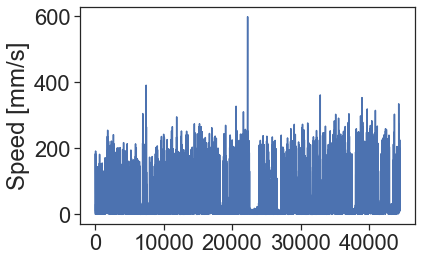

In [5]:
TYP = 1 # 0 to load sim data, 1 to load real ones

# reconstruction parameters
K_lle = 10
LAMBDA = 1

if TYP:
    ds_plt = 1 # downsample for plotting
    down = 3 # downsampling param for manifold embedding
    LBL = 'real'
    print('Loading real data...')
    for d,folder,files in os.walk(realDir):
        continue
    file = [s for s in files if 'Track' in s]
    temp = io.loadmat(realDir+'/'+file[0])
    phi = temp['phi']; x = temp['x']; y = temp['y']; r = temp['r']
    speed = temp['speed']; Time = temp['time']
    file = [s for s in files if 'spikes' in s]
    temp = io.loadmat(realDir+'/'+file[0])
    spikes = temp['spikes']
    params = temp['params']
    file = [s for s in files if 'fissa' in s]
    temp = io.loadmat(realDir+'/'+file[0])
    dff =  temp['ddf_f']
else:
    ds_plt = 1
    down = 2
    LBL = 'sim'
    print('Loading simulated data...')
    temp = io.loadmat(simPath)
    dff = temp['dFonF_control']
    phi = temp['position_control'].flatten()
    pfMap = temp['pfMap_control']
    
# find  active times
if TYP:
    speed_thr = 20
    active = speed.flatten() > speed_thr
    print('Active samples:%s - Immobility samples:%s'%(sum(active),sum(~active)))
    plt.plot(speed); plt.ylabel('Speed [mm/s]')
#     filter activity for active times only
    dff_og = dff.copy() # save the full activity
    dff = dff[:,active]
    phi_og = phi.copy() # save the full phi
    phi = phi[active].flatten()
    
# initialise dict to store decoding scores
DIM = {}
RMSE = {}; R = {}
var_expl = {}; var_expl_embd = {}
rec_err = {}; rec_corr = {}
var_svd = {}; H = {}

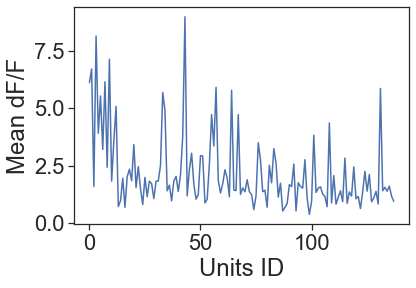

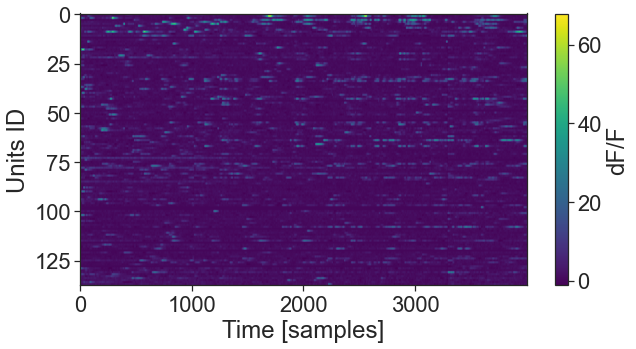

In [7]:
# Plot dFF activity examples
plt.figure(); plt.plot(np.mean(dff,1))
plt.ylabel('Mean dF/F'); plt.xlabel('Units ID')
plt.figure(figsize=(10,5))
plt.imshow(dff[:,:4000],cmap='viridis', aspect='auto'); cbar = plt.colorbar()
plt.xlabel('Time [samples]'); plt.ylabel('Units ID')
cbar.set_label('dF/F')

## Cosine distance matrix

In [8]:
# obtain cosine distance matrix
if TYP: down = 3 # downsampling factor for speeding up calculations
else: down = 2 # no downsampling foir sim data
X = dff[:,::down].T
D = cosine_distances(X)

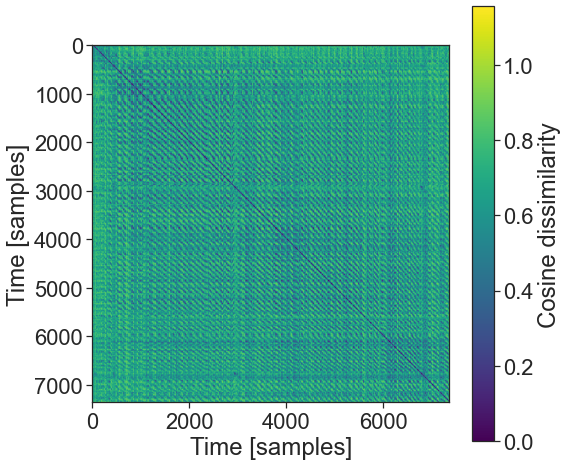

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(D,cmap='viridis'); cbar = plt.colorbar(); cbar.set_label('Cosine dissimilarity')
plt.xlabel('Time [samples]'); plt.ylabel('Time [samples]');

## PCA

In [10]:
pca = PCA(n_components=DIMS)
x_embd = pca.fit_transform(X)
x_embd = x_embd / np.max(np.abs(x_embd)) # normalise the values
AXIS_LIM = np.max(x_embd)

<Figure size 432x288 with 0 Axes>

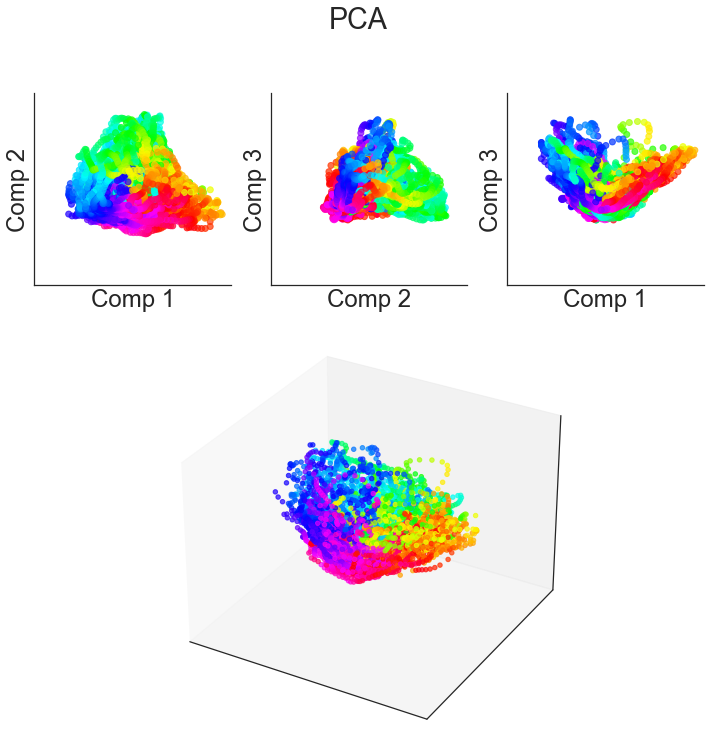

In [11]:
plt.set_cmap('hsv') # circular cmap
MIN = -AXIS_LIM
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('PCA')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi[::down][::ds_plt]
scat = ax.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/PCA_'+LBL+'.png')
    plt.savefig(figDirReal+'/PCA_'+LBL+'.svg')
else:
    plt.savefig(figDirSim+'/PCA_'+LBL+'.png')
    plt.savefig(figDirSim+'/PCA_'+LBL+'.svg')

In [12]:
# plt.plot(cmap/100)
# plt.plot(x_embd[:,0])
# plt.ylim(-5,5)
# plt.figure()
# plt.plot(cmap/100, x_embd[:,0])

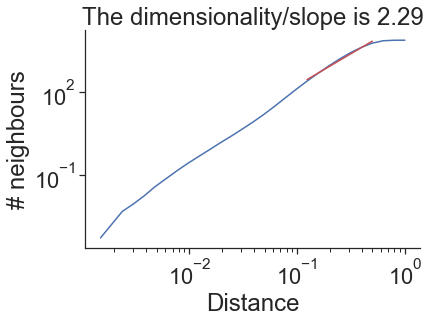

In [13]:
### Dimensionality
EMBD = 'PCA'
nstep = 30
Nneigh, radii, p = intrinsic_dimensionality(x_embd, nstep=nstep, metric='euclidean', fit='std', thr_start=100, thr_fi=5e3)
DIM[EMBD] = p[0]

In [12]:
### OLE  decoding
EMBD = 'PCA'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] =rmse; R[EMBD][n,c] = r
        c+=1

In [316]:
# ### Dimensionality score

# # scale Y to match X
# Y = x_embd
# radY = np.percentile(Y-np.mean(Y), 95)
# radX = np.percentile(X-np.mean(X), 95)
# Y_sc = radX/radY * (Y-np.mean(Y))

# ### Reconstruction error
# var_expl[EMBD] = []
# rec_err[EMBD] = []
# for dim in range(DIMS):
#     # obtain og high-dim activity and its embedding
#     if TYP:
#         Y = Y_sc[::2,:dim+1]
#         X_ = X[::2].copy()
#     else:
#         Y = Y_sc[:,:dim+1]
#         X_ = X.copy()
#     # obtain the RBF interpolation  of the embedding
#     gamma = np.var(Y)*10
#     K = mtr.pairwise_kernels(Y, metric='rbf', gamma=gamma)
#     # Obtain inverse-mapping A
#     A = np.linalg.pinv(K).dot(X_)
#     # Reconstruct the data
#     X_rec = np.dot(K,A)
#     s1 = np.mean((X_ - X_rec)**2)
#     s2 = np.mean((X_ - np.mean(X_))**2)
#     var_expl[EMBD].append(1 - s1/s2)
#     rec_err[EMBD].append(np.mean(np.sqrt((X_-X_rec)**2)))
#     print('.')
    
# ### E-ball fit
# H[EMBD] = []
# for dim in range(DIMS):
#     Y = Y_sc[:,:dim+1]
#     for n in range(2): # loop for +ve / -ve unit vectors
#         for d in range(dim+1):
#             v = np.zeros(dim+1)
#             if n: v[d] = 1
#             else: v[d] = -1
#             # Apply it to test data
#             H[EMBD].append(np.min(np.sqrt((v-Y)**2)))

In [13]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


Text(0.5, 1.0, 'Reconstructed')

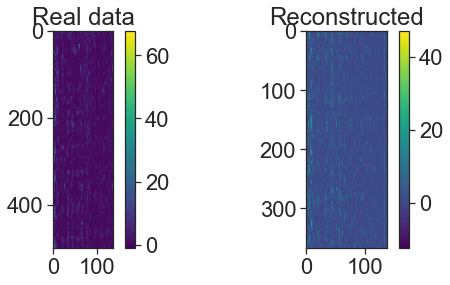

In [318]:
# Visualise a reconstruction example
plt.figure(figsize=(9,4));
plt.subplot(121)
plt.imshow(X_[:500],cmap='viridis'); plt.colorbar()
plt.title('Real data')
plt.subplot(122)
plt.imshow(X_rec[:500],cmap='viridis'); plt.colorbar()
plt.title('Reconstructed')

## CMDSCALE (classic  MDS)

In [14]:
# fit embedding
x_embd,eig_mds_dff = cmdscale(D)
x_embd = x_embd / np.max(x_embd)

<Figure size 432x288 with 0 Axes>

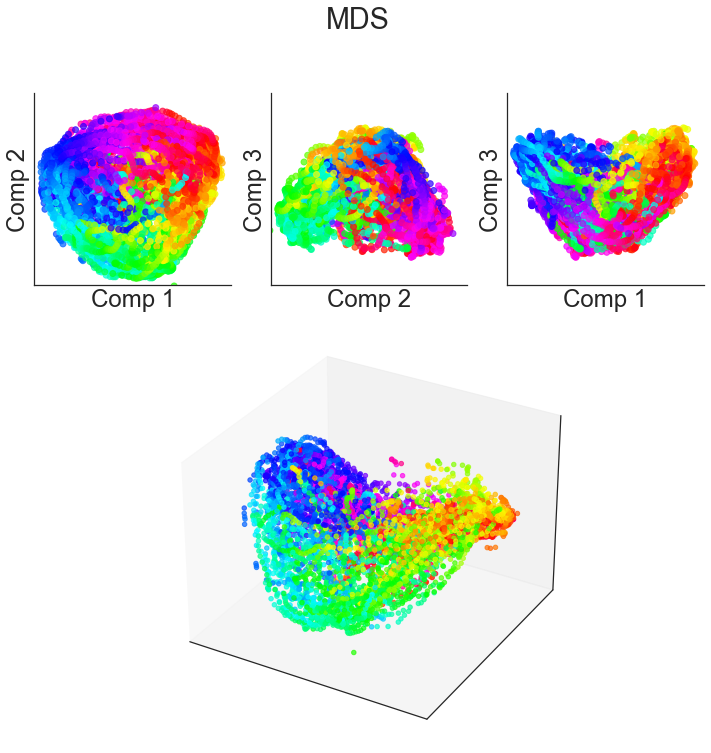

In [15]:
plt.set_cmap('hsv') # circular cmap
MIN = -AXIS_LIM
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('MDS')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi[::down][::ds_plt]
scat = ax.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/MDS_'+LBL+'.png')
    plt.savefig(figDirReal+'/MDS_'+LBL+'.svg')
else:
    plt.savefig(figDirSim+'/MDS_'+LBL+'.png')
    plt.savefig(figDirSim+'/MDS_'+LBL+'.svg')

Text(0.5, 0, 'Number of dimensions')

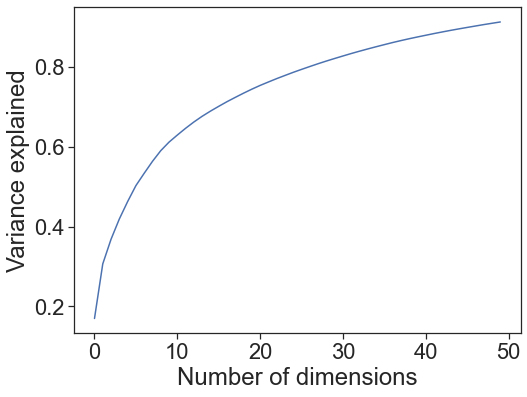

In [16]:
evals_mds_ = eig_mds_dff[eig_mds_dff>0] / np.sum(eig_mds_dff[eig_mds_dff>0])
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(evals_mds_)[:50])
plt.ylabel('Variance explained')
plt.xlabel('Number of dimensions')

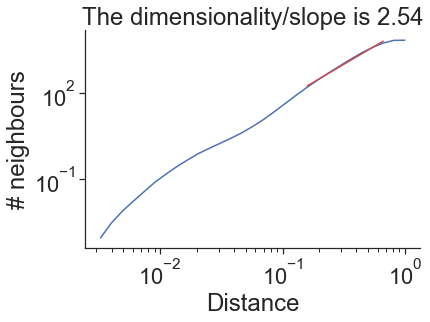

In [17]:
### Dimensionality
EMBD = 'MDS'
nstep = 30
Nneigh, radii, p = intrinsic_dimensionality(x_embd[:,:DIMS], nstep=nstep, metric='euclidean', fit='std',\
                                            thr_start=100, thr_fi=5e3)
DIM[EMBD] = p[0]

In [17]:
### OLE  decoding
EMBD = 'MDS'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] =rmse; R[EMBD][n,c] = r
        c+=1

In [18]:
# ### Dimensionality score

# # scale Y (low dim) to match X (high dim)
# Y = x_embd
# radY = np.percentile(Y-np.mean(Y), 95)
# radX = np.percentile(X-np.mean(X), 95)
# Y_sc = radX/radY * (Y-np.mean(Y))

# ### Reconstruction error
# var_expl[EMBD] = []
# rec_err[EMBD] = []
# for dim in range(1):
#     # obtain og high-dim activity and its embedding
#     if TYP:
#         Y = Y_sc[::2,:dim+1]
#         X_ = X[::2].copy()
#     else:
#         Y = Y_sc[:,:dim+1]
#         X_ = X.copy()
#     # obtain the RBF interpolation  of the embedding
#     gamma = np.var(Y)*10
#     K = mtr.pairwise_kernels(Y, metric='rbf', gamma=gamma)
#     # Obtain inverse-mapping A
#     A = np.linalg.pinv(K).dot(X_)
#     # Reconstruct the data
#     X_rec = np.dot(K,A)
#     s1 = np.mean((X_ - X_rec)**2)
#     s2 = np.mean((X_ - np.mean(X_))**2)
#     var_expl[EMBD].append(1 - s1/s2)
#     rec_err[EMBD].append(np.mean(np.sqrt((X_-X_rec)**2)))
#     print('.')
    
# ### E-ball fit
# H[EMBD] = []
# for dim in range(DIMS):
#     Y = Y_sc[:,:dim+1]
#     for n in range(2): # loop for +ve / -ve unit vectors
#         for d in range(dim+1):
#             v = np.zeros(dim+1)
#             if n: v[d] = 1
#             else: v[d] = -1
#             # Apply it to test data
#             H[EMBD].append(np.min(np.sqrt((v-Y)**2)))

In [19]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


Text(0.5, 1.0, 'Reconstructed')

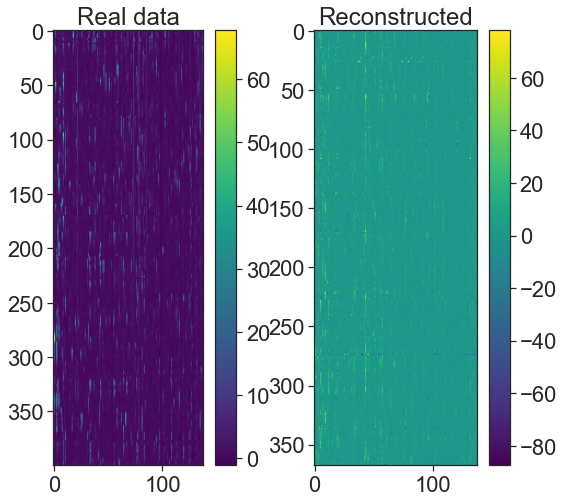

In [325]:
# Visualise a reconstruction example
plt.figure(figsize=(9,8));
plt.subplot(121);
plt.imshow(X_[:400],cmap='viridis'); plt.colorbar()
plt.title('Real data')
plt.subplot(122)
plt.imshow(X_rec[:400],cmap='viridis'); plt.colorbar()
plt.title('Reconstructed')

## ISOMAP

In [18]:
# fit embedding
COS = 1 # set to 1 for embedding the cosine distance matrix
if COS:
    if TYP: isomap = Isomap(n_components=DIMS, n_neighbors=40)
    else: isomap = Isomap(n_components=DIMS, n_neighbors=10)
    x_embd = isomap.fit_transform(D)
else:
    if TYP: isomap = Isomap(n_components=DIMS, n_neighbors=40, metric='minkowski')
    else: isomap = Isomap(n_components=DIMS, n_neighbors=10, metric='minkowski')
    x_embd = isomap.fit_transform(X)
x_embd = x_embd / np.max(x_embd)

<Figure size 432x288 with 0 Axes>

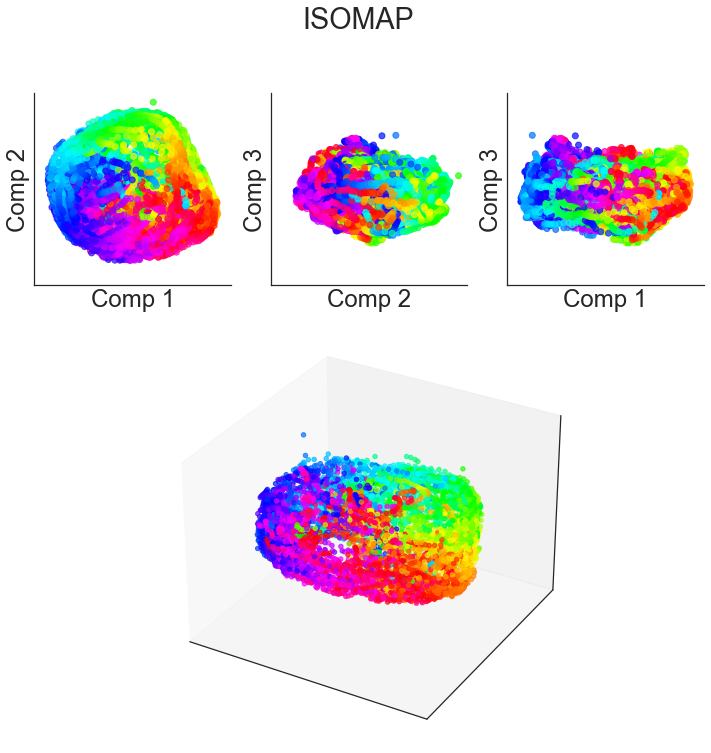

In [19]:
plt.set_cmap('hsv') # circular cmap
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('ISOMAP')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi[::down][::ds_plt]
scat = ax.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlim([-AXIS_LIM,AXIS_LIM])
ax.set_ylim([-AXIS_LIM,AXIS_LIM])
ax.set_zlim([-AXIS_LIM,AXIS_LIM])
# ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/Isomap_'+LBL+'.png')
    plt.savefig(figDirReal+'/Isomap_'+LBL+'.svg')
else:
    plt.savefig(figDirSim+'/Isomap_'+LBL+'.png')
    plt.savefig(figDirSim+'/Isomap_'+LBL+'.svg')

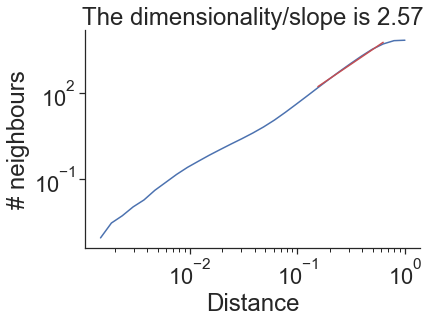

In [20]:
### Dimensionality
EMBD = 'ISO'
nstep = 30
Nneigh, radii, p = intrinsic_dimensionality(x_embd, nstep=nstep, metric='euclidean', fit='std', thr_start=100, thr_fi=5e3)
DIM[EMBD] = p[0]

In [22]:
### OLE  decoding
EMBD = 'ISO'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] =rmse; R[EMBD][n,c] = r
        c+=1

In [23]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


Text(0.5, 1.0, 'Reconstructed')

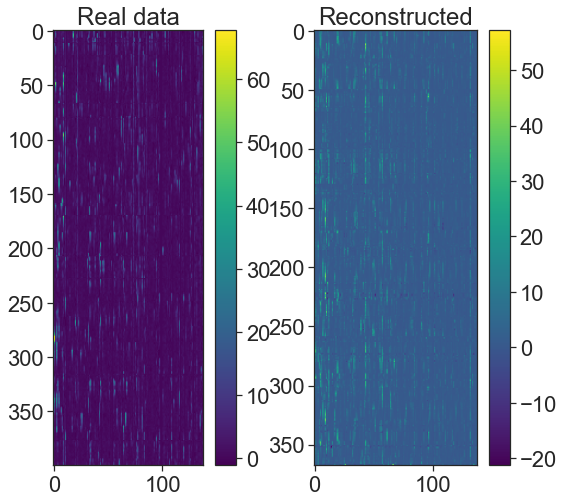

In [330]:
# Visualise a reconstruction example
plt.figure(figsize=(9,8));
plt.subplot(121);
plt.imshow(X_[:400],cmap='viridis'); plt.colorbar()
plt.title('Real data')
plt.subplot(122)
plt.imshow(X_rec[:400],cmap='viridis'); plt.colorbar()
plt.title('Reconstructed')

## LLE

In [21]:
# fit embedding
if TYP: 
    lle = LocallyLinearEmbedding(n_components=DIMS, n_neighbors=60, method='modified')
    x_embd = lle.fit_transform(D)
else:
    lle = LocallyLinearEmbedding(n_components=DIMS, n_neighbors=10, method='modified')
    x_embd = lle.fit_transform(X)
x_embd = x_embd / np.max(x_embd)

<Figure size 432x288 with 0 Axes>

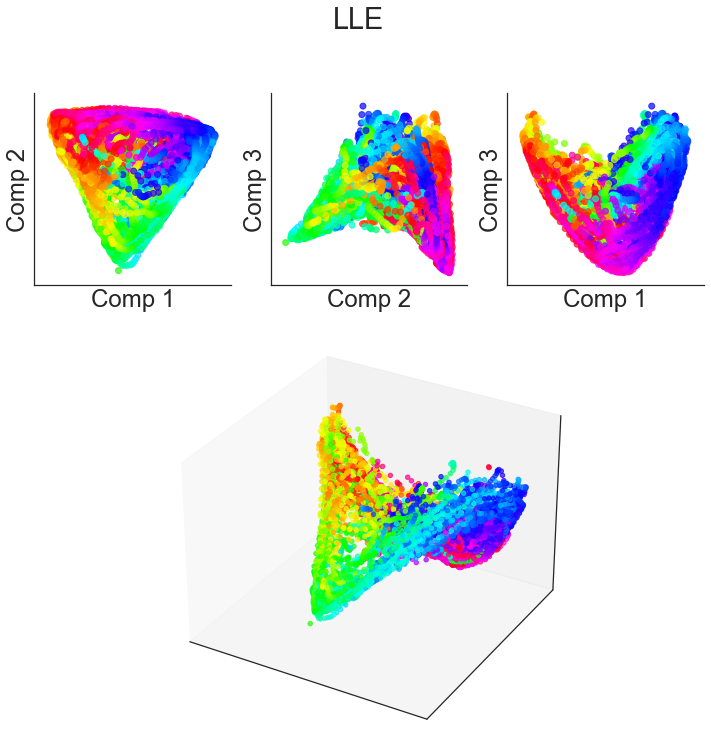

In [22]:
plt.set_cmap('hsv') # circular cmap
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('LLE')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi[::down]
scat = ax.scatter(x_embd[:,0], x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
MIN = np.min(x_embd,0)
MAX = np.max(x_embd,0)
ax.set_xlim([MIN[0]-.1,MAX[0]])
ax.set_ylim([MIN[1]-.1,MAX[1]+.1])
ax.set_zlim([MIN[2]-.1,MAX[2]+.1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(MIN,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(MIN),'','0','',str(MAX)])
# ax.set_yticks(np.arange(MIN,MAX+.1,.5))
# ax.set_yticklabels([str(MIN),'','0','',str(MAX)])
# ax.set_zticks(np.arange(MIN,MAX+.1,.5))
# ax.set_zticklabels([str(MIN),'','0','',str(MAX)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0], x_embd[:,1], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[0]-.1,MAX[0]+.1]); ax.set_ylim([MIN[1]-.1,MAX[1]+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[1]-.1,MAX[1]+.1]); ax.set_ylim([MIN[2]-.1,MAX[2]+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[0]-.1,MAX[0]+.1]); ax.set_ylim([MIN[2]-.1,MAX[2]+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/LLE_'+LBL+'.png')
    plt.savefig(figDirReal+'/LLE_'+LBL+'.svg')
else:
    plt.savefig(figDirSim+'/LLE_'+LBL+'.png')
    plt.savefig(figDirSim+'/LLE_'+LBL+'.svg')

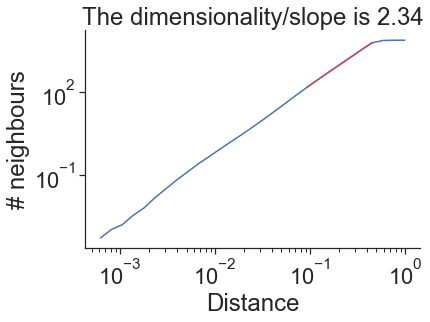

In [23]:
### Dimensionality
EMBD = 'LLE'
nstep = 30
Nneigh, radii, p = intrinsic_dimensionality(x_embd, nstep=nstep, metric='euclidean', fit='std', thr_start=100, thr_fi=5e3)
DIM[EMBD] = p[0]

In [26]:
### OLE  decoding
EMBD = 'LLE'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] =rmse; R[EMBD][n,c] = r
        c+=1

In [27]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


## Laplacian eigenmaps (Spectral embedding)

In [24]:
# fit embedding
if TYP:
    nn = NearestNeighbors(n_neighbors=60, metric='cosine')
    nn.fit(X)
    adj = nn.kneighbors_graph(X)
    SE = SpectralEmbedding(n_components=DIMS, affinity='precomputed_nearest_neighbors', n_neighbors=60)
    x_embd = SE.fit_transform(adj)
else:
    SE = SpectralEmbedding(n_components=DIMS, affinity='nearest_neighbors', n_neighbors=10)
    x_embd = SE.fit_transform(X)
x_embd = x_embd / np.max(x_embd)

<Figure size 432x288 with 0 Axes>

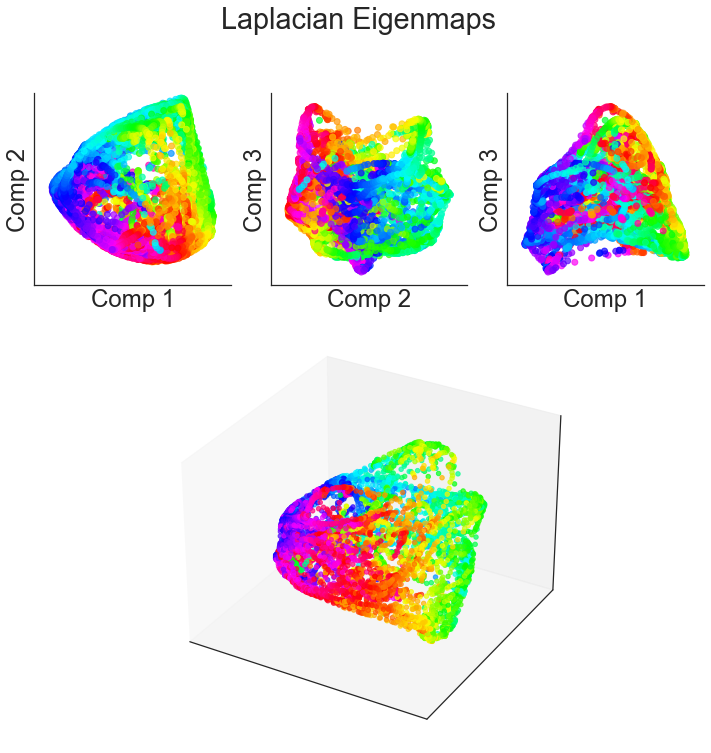

In [25]:
plt.set_cmap('hsv') # circular cmap
MIN = MIN
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('Laplacian Eigenmaps')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi[::down]
scat = ax.scatter(x_embd[:,0], x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
MIN = np.min(x_embd,0)
MAX = np.max(x_embd,0)
ax.set_xlim([MIN[0]-.1,MAX[0]+.1])
ax.set_ylim([MIN[1]-.1,MAX[1]+.1])
ax.set_zlim([MIN[2]-.1,MAX[2]+.1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(MIN,MAX+.1,.5))
# ax.set_xticklabels([str(M),'','0','',str(MAX)])
# ax.set_yticks(np.arange(M,MAX+.1,.5))
# ax.set_yticklabels([str(M),'','0','',str(MAX)])
# ax.set_zticks(np.arange(M,MAX+.1,.5))
# ax.set_zticklabels([str(M),'','0','',str(MAX)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0], x_embd[:,1], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[0]-.1,MAX[0]+.1]); ax.set_ylim([MIN[0]-.1,MAX[0]+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[1]-.1,MAX[1]+.1]); ax.set_ylim([MIN[2]-.1,MAX[2]+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[0]-.1,MAX[0]+.1]); ax.set_ylim([MIN[2]-.1,MAX[2]+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/Laplacian_'+LBL+'.svg')
    plt.savefig(figDirReal+'/Laplacian_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/Laplacian_'+LBL+'.svg')
    plt.savefig(figDirSim+'/Laplacian_'+LBL+'.png')

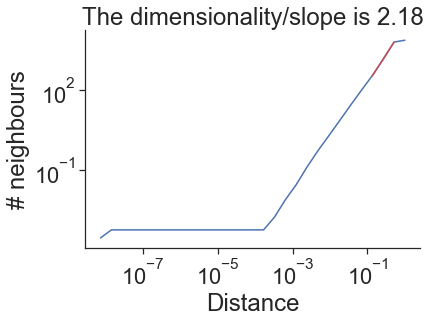

In [26]:
### Dimensionality
EMBD = 'LEM'
nstep = 30
Nneigh, radii, p = intrinsic_dimensionality(x_embd, nstep=nstep, metric='euclidean', fit='std', thr_start=100, thr_fi=5e3)
DIM[EMBD] = p[0]

In [ ]:
### OLE  decoding
EMBD = 'LEM'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1

In [ ]:
### Reconstruction error
# scale Y to match X
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

## GPFA

In [14]:
if TYP:
    LBL = 'real'
    temp = io.loadmat(dataDir+'gpfaOutput_hippocampalData.mat')
    x_embd = np.array(temp['gpfa_Y']).T
    x_embd = x_embd / np.max(x_embd) # normalise
    phi_ = np.array(temp['gpfa_position']).flatten()
    X_gpfa = temp['gpfa_X'].T # data, pos, time, spikes
else:
    LBL = 'sim'
    temp = io.loadmat(dataDir+'gpfaOutput_simulated.mat')
    x_embd = np.array(temp['gpfaOutputSim'][0,0][0]).T
    x_embd = x_embd / np.max(x_embd) # normalise
    phi_ = np.array(temp['gpfaOutputSim'][0,0][1]).flatten()
    temp2 = io.loadmat(dataDir+'gpfaData_Simulated.mat')
    data_ = np.array(temp2['data'][0,0][0]).T # data, pos, 

In [15]:
temp.keys()

dict_keys(['__header__', '__version__', '__globals__', 'gpfa_X', 'gpfa_Y', 'gpfa_position'])

<Figure size 432x288 with 0 Axes>

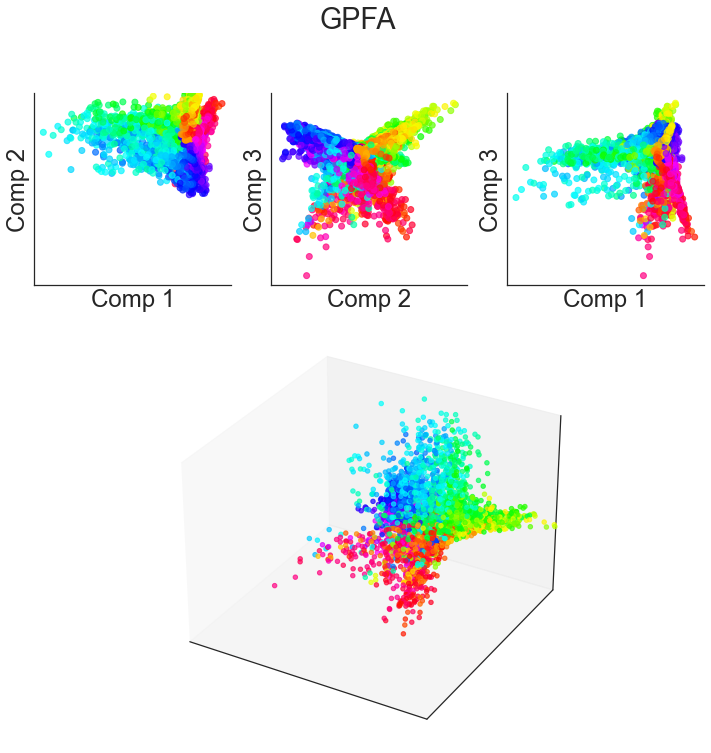

In [551]:
plt.set_cmap('hsv') # circular cmap
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('GPFA')
# 3D projectiona
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi_
scat = ax.scatter(x_embd[:,1], x_embd[:,2], -x_embd[:,0], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
MIN = np.min(x_embd,0)
MAX = np.max(x_embd,0)
ax.set_xlim([MIN[0]-.1,MAX[0]+.1])
ax.set_ylim([MIN[1]-.1,MAX[1]+.1])
ax.set_zlim([MIN[2]-.1,MAX[2]+.1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(MIN,MAX+.1,.5))
# ax.set_xticklabels([str(M),'','0','',str(MAX)])
# ax.set_yticks(np.arange(M,MAX+.1,.5))
# ax.set_yticklabels([str(M),'','0','',str(MAX)])
# ax.set_zticks(np.arange(M,MAX+.1,.5))
# ax.set_zticklabels([str(M),'','0','',str(MAX)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0], x_embd[:,1], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[0]-.1,MAX[0]+.1]); ax.set_ylim([MIN[0]-.1,MAX[0]+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[1]-.1,MAX[1]+.1]); ax.set_ylim([MIN[2]-.1,MAX[2]+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[0]-.1,MAX[0]+.1]); ax.set_ylim([MIN[2]-.1,MAX[2]+.1])
sns.despine()

# saving
if TYP:
    plt.savefig(figDirReal+'/gpfa_'+LBL+'.svg')
    plt.savefig(figDirReal+'/gpfa_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/gpfa_'+LBL+'.svg')
    plt.savefig(figDirSim+'/gpfa_'+LBL+'.png')

In [552]:
### OLE  decoding
EMBD = 'GPFA'
N = DIMS
cv = 10
Y = phi_ # angular position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n+1] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1

In [553]:
### Reconstruction error
# scale Y to match X
EMBD = 'GPFA'
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    Y = Y_sc[:,:dim+1]
    X_ = X_gpfa.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

.
.
.
.
.


## GPFA elephant

In [10]:
import neo
import quantities as pq

# obtrain trial by trial activity for gpfa embedding
down = 3
phi_a = phi[::down]
spikes_a = spikes[:,active][:,::down]
sampF = 30/down
# a = neo.AnalogSignal(X, units=pq.dimensionless, sampling_rate=10*pq.Hz)
X_trials = []
laps_idx = []
m = 0
for n,p in enumerate(phi_a[::]):
    if p<5 and phi_a[n+1]>355:
        if n<20: m = n # first lap
        else:
            print(m,n, p)
            X_ = spikes_a[:10,m:n]
            m = n
            laps_idx.append([m,n])
            neospk = []
            for s in range(X_.shape[0]):
                spk = neo.SpikeTrain(np.where(X_[s,:])[0]*sampF*pq.ms, t_stop=X.shape[0]/sampF*pq.s)
                neospk.append(spk)
            X_trials.append(neospk)

2 180 3.544278
180 303 1.187877
303 449 2.307193
449 581 0.266008
581 725 1.342905
725 885 3.056423
885 1044 0.624673
1044 1048 0.234839
1048 1098 2.4762
1098 1266 0.060441
1266 1411 1.829872
1411 1548 1.44637
1548 1690 4.003446
1690 1817 3.448599
1817 2053 2.167806
2053 2178 2.898205
2178 2577 1.236948
2577 2816 2.140213
2816 2927 1.792983
2927 3071 0.065914
3071 3195 1.031342
3195 3447 2.509082
3447 3450 1.448673
3450 3680 1.439444
3680 3809 2.294052
3809 3921 1.946474
3921 4054 0.594306
4054 4198 1.339402
4198 4328 3.071803
4328 4442 2.636011
4442 4557 1.85965
4557 4665 2.650626
4665 4779 1.709615
4779 4882 2.730641
4882 5001 4.749863
5001 5111 0.031536
5111 5225 1.625022
5225 5443 0.021583
5443 5541 2.661221
5541 5660 2.725171
5660 5771 0.382391
5771 5864 4.484707
5864 5969 1.860839
5969 6002 2.55538
6002 6113 4.109848
6113 6197 2.396365
6197 6292 0.401129
6292 6386 2.049931
6386 6482 2.331424
6482 6755 1.63252
6755 6879 1.387301
6879 6997 2.157243
6997 7105 2.191058
7105 7234 1.91

In [12]:
bs = 20*pq.ms
SE = GPFA(x_dim=DIMS, bin_size=bs)
x_embd = SE.fit_transform(X_trials[:5])

Initializing parameters using factor analysis...

Fitting GPFA model...


KeyboardInterrupt: 

## tSNE

In [27]:
# fit embedding
if TYP:
    SE = TSNE(n_components=3, metric='euclidean', perplexity=90, random_state=42)
    x_embd = SE.fit_transform(X)
else:
    SE = TSNE(n_components=3, metric='euclidean', perplexity=40, random_state=42)
    x_embd = SE.fit_transform(X)
x_embd = x_embd / np.max(x_embd)

<Figure size 432x288 with 0 Axes>

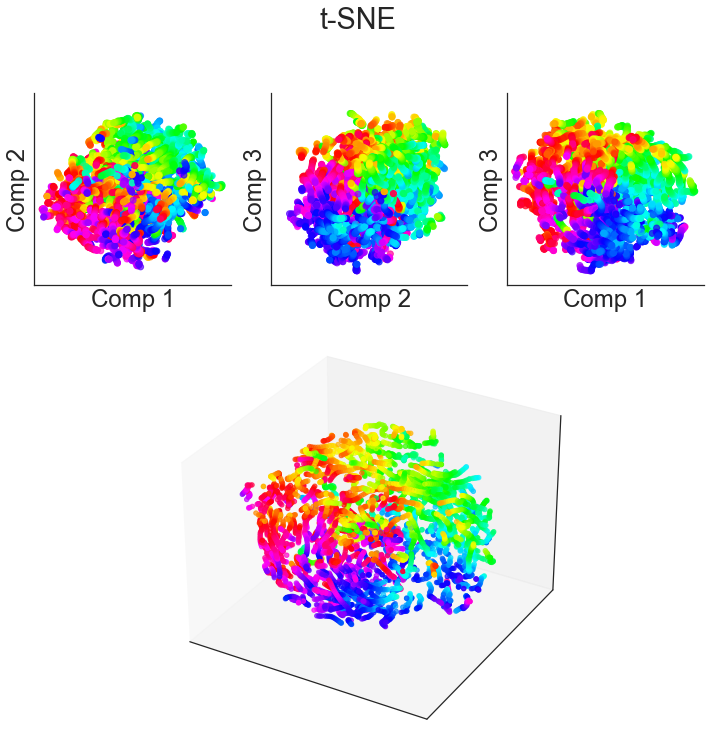

In [28]:
plt.set_cmap('hsv') # circular cmap
MIN = -AXIS_LIM
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
cmap = phi[::down][::ds_plt]
plt.suptitle('t-SNE')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
scat = ax.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,1][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([-AXIS_LIM-.1,AXIS_LIM+.1]); ax.set_ylim([-AXIS_LIM-.1,AXIS_LIM+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/tSNE_'+LBL+'.png')
    plt.savefig(figDirReal+'/tSNE_'+LBL+'.svg')
else:
    plt.savefig(figDirSim+'/tSNE_'+LBL+'.png')
    plt.savefig(figDirSim+'/tSNE_'+LBL+'.svg')

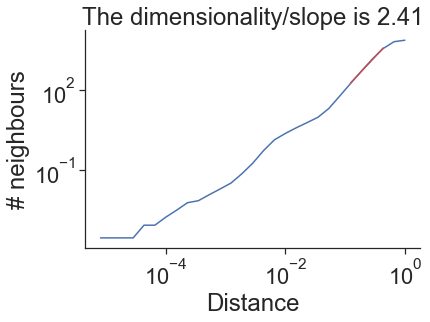

In [29]:
### Dimensionality
EMBD = 't-SNE'
nstep = 30
Nneigh, radii, p = intrinsic_dimensionality(x_embd, nstep=nstep, metric='euclidean', fit='std', thr_start=100, thr_fi=5e3)
DIM[EMBD] = p[0]

In [ ]:
### OLE  decoding
EMBD = 't-SNE'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.ones((N,cv))*np.nan; R[EMBD] = np.ones((N,cv))*np.nan
for n in range(3): # loop over dimensions
    # refit embedding with n+1 dims
    if TYP:
        E = TSNE(n_components=n+1, metric='cosine', perplexity=90, random_state=42)
    else:
        E = TSNE(n_components=n+1, metric='cosine', perplexity=20, random_state=42)
    X_ = E.fit_transform(X)
    X_ = centre_scale(X_)
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1
    print('.')

In [ ]:
### Reconstruction error
# scale Y to match X
EMBD = 't-SNE'
Y = x_embd
radY = np.percentile(Y-np.mean(Y), 95)
radX = np.percentile(X-np.mean(X), 95)
Y_sc = radX/radY * (Y-np.mean(Y))
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.ones((N,cv))*np.nan
var_expl[EMBD] = np.ones((N,cv))*np.nan
rec_err[EMBD] = np.ones((N,cv))*np.nan
rec_corr[EMBD] = np.ones((N,cv))*np.nan
for dim in range(3):
    # obtain og high-dim activity and its embedding
    if TYP:
        # refit embedding with n+1 dims
        E = TSNE(n_components=dim+1, metric='cosine', perplexity=90, random_state=42)
        Y = E.fit_transform(X)
        Y = centre_scale(Y)
        # scale embedding
        radY = np.percentile(Y-np.mean(Y), 95)
        radX = np.percentile(X-np.mean(X), 95)
        Y_sc = radX/radY * (Y-np.mean(Y))
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        # refit embedding with n+1 dims
        E = TSNE(n_components=dim+1, metric='cosine', perplexity=20, random_state=42)
        Y = E.fit_transform(X)
        Y = centre_scale(Y)
        # scale embedding
        radY = np.percentile(Y-np.mean(Y), 95)
        radX = np.percentile(X-np.mean(X), 95)
        Y_sc = radX/radY * (Y-np.mean(Y))
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

## UMAP

In [30]:
# fit embedding
if TYP:
    SE = umap.UMAP(n_components=DIMS, metric='cosine', n_neighbors=70, random_state=42)
    x_embd = SE.fit_transform(X)
else:
    SE = umap.UMAP(n_components=DIMS, metric='cosine', n_neighbors=20, random_state=4)
    x_embd = SE.fit_transform(X)
x_embd = centre_scale(x_embd)

<Figure size 432x288 with 0 Axes>

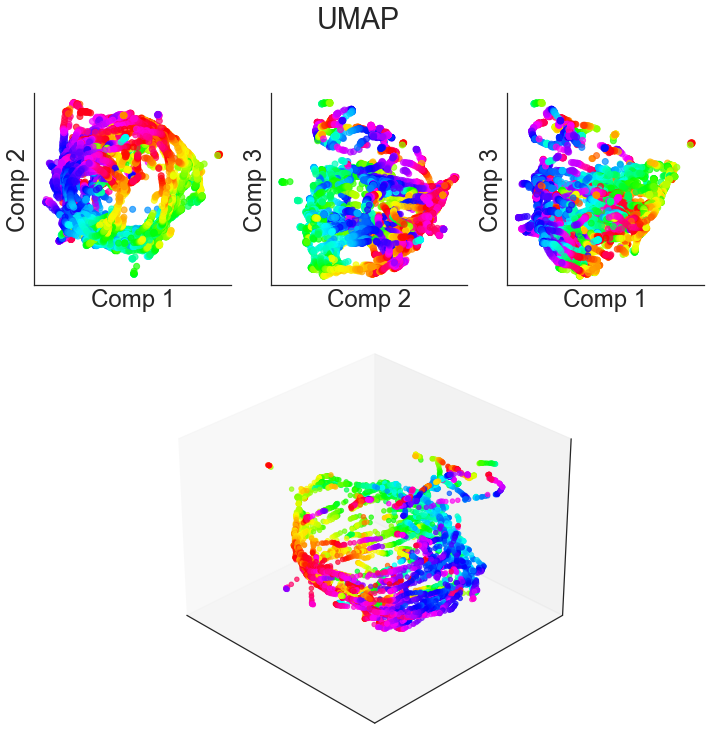

In [31]:
plt.set_cmap('hsv') # circular cmap
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
cmap = phi[::down][::ds_plt]
plt.suptitle('UMAP')
# 3D projection
ax = fig.add_subplot(grid[1:,:], projection='3d')
scat = ax.scatter(-x_embd[:,0][::ds_plt], -x_embd[:,1][::ds_plt], x_embd[:,2][::ds_plt], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
ax.view_init(elev=30., azim=-45)
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
MIN = np.min(x_embd,0)
MAX = np.max(x_embd,0)
ax.set_xlim([MIN[0]-.1,MAX[0]+.1])
ax.set_ylim([MIN[1]-.1,MAX[1]+.1])
ax.set_zlim([MIN[2]-.1,MAX[2]+.1])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(MIN,MAX+.1,.5))
# ax.set_xticklabels([str(M),'','0','',str(MAX)])
# ax.set_yticks(np.arange(M,MAX+.1,.5))
# ax.set_yticklabels([str(M),'','0','',str(MAX)])
# ax.set_zticks(np.arange(M,MAX+.1,.5))
# ax.set_zticklabels([str(M),'','0','',str(MAX)])

# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0], x_embd[:,1], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[0]-.1,MAX[0]+.1]); ax.set_ylim([MIN[0]-.1,MAX[0]+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[1]-.1,MAX[1]+.1]); ax.set_ylim([MIN[2]-.1,MAX[2]+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN[0]-.1,MAX[0]+.1]); ax.set_ylim([MIN[2]-.1,MAX[2]+.1])
sns.despine()

#  saving
if TYP:
    plt.savefig(figDirReal+'/UMAP_'+LBL+'.png')
    plt.savefig(figDirReal+'/UMAP_'+LBL+'.svg')
else:
    plt.savefig(figDirSim+'/UMAP_'+LBL+'.png')
    plt.savefig(figDirSim+'/UMAP_'+LBL+'.svg')

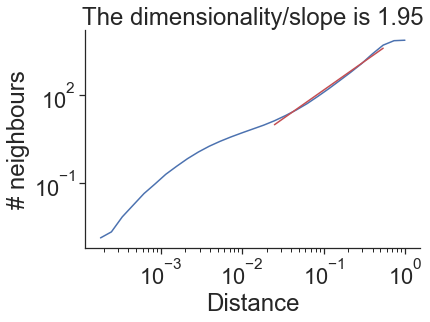

In [32]:
### Dimensionality
EMBD = 'UMAP'
nstep = 30
Nneigh, radii, p = intrinsic_dimensionality(x_embd, nstep=nstep, metric='euclidean', fit='std', thr_start=10, thr_fi=5e3)
DIM[EMBD] = p[0]

In [ ]:
### OLE  decoding
EMBD = 'UMAP'
N = DIMS
cv = 10
Y = phi[::down].flatten() # angulat position
RMSE[EMBD] = np.ones((N,cv))*np.nan; R[EMBD] = np.ones((N,cv))*np.nan
for n in range(N): # loop over dimensions
    # refit embedding with n+1 dims
    if TYP:
        E = umap.UMAP(n_components=n+1, metric='cosine', n_neighbors=60, random_state=42)
        x_embd = SE.fit_transform(X)
    else:
        E = umap.UMAP(n_components=n+1, metric='cosine', n_neighbors=20, random_state=4)
    X_ = E.fit_transform(X)
    X_ = centre_scale(X_)
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1
    print('.')

In [ ]:
### Reconstruction error
EMBD = 'UMAP'
# 10-fold activity reconstruction
cv = 10
var_expl_embd[EMBD] = np.zeros((DIMS,cv))
var_expl[EMBD] = np.zeros((DIMS,cv))
rec_err[EMBD] = np.zeros((DIMS,cv))
rec_corr[EMBD] = np.zeros((DIMS,cv))
for dim in range(DIMS):
    # obtain og high-dim activity and its embedding
    if TYP:
        # refit embedding with n+1 dims
        E = umap.UMAP(n_components=dim+1, metric='cosine', n_neighbors=60, random_state=42)
        Y = E.fit_transform(X)
        Y = centre_scale(Y)
        # scale embedding
        radY = np.percentile(Y-np.mean(Y), 95)
        radX = np.percentile(X-np.mean(X), 95)
        Y_sc = radX/radY * (Y-np.mean(Y))
        Y = Y_sc[::2,:dim+1]
        X_ = X[::2].copy()
    else:
        # refit embedding with n+1 dims
        E = umap.UMAP(n_components=dim+1, metric='cosine', n_neighbors=20, random_state=4)
        Y = E.fit_transform(X)
        Y = centre_scale(Y)
        # scale embedding
        radY = np.percentile(Y-np.mean(Y), 95)
        radX = np.percentile(X-np.mean(X), 95)
        Y_sc = radX/radY * (Y-np.mean(Y))
        Y = Y_sc[:,:dim+1]
        X_ = X.copy()
    kf = KFold(n_splits=cv)
    c = 0
    for train_idx, test_idx in kf.split(X_): # number of cv folds
        # lle reconstruction
        X_rec = new_LLE_pts(Y[train_idx,:].T, X_[train_idx,:].T, K_lle, Y[test_idx,:].T, LAMBDA)
        s0 = np.mean((Y[test_idx].sum(1) - X_[test_idx].sum(1))**2)
        s1 = np.mean((X_[test_idx] - X_rec)**2)
        s2 = np.mean((X_[test_idx] - np.mean(X_[test_idx]))**2)
        var_expl_embd[EMBD][dim,c] = 1 - s0/s2
        var_expl[EMBD][dim,c] = 1 - s1/s2
        rec_err[EMBD][dim,c] = np.mean(np.sqrt((X_[test_idx]-X_rec)**2))
        real = X_[test_idx].flatten()
        dec = X_rec.flatten()
        rec_corr[EMBD][dim,c] = np.corrcoef(real, dec)[0,1]
        c+=1
    print('.')

## Dimensionality

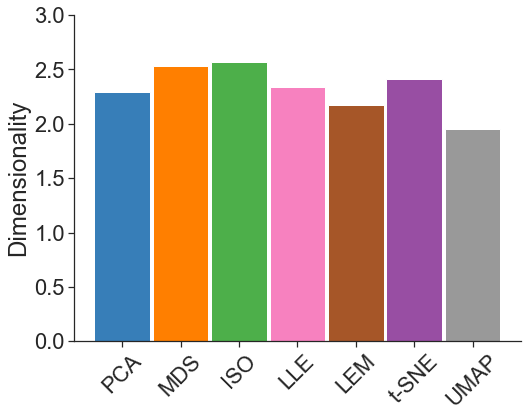

In [33]:
plt.figure(figsize=(8,6))
LBL = 'real'
lbl = ['PCA', 'MDS', 'ISO', 'LLE', 'LEM', 't-SNE', 'UMAP']
for n,e in enumerate(lbl):
    plt.bar(n, DIM[e], width=.95, color=colb[n], label=e)
sns.despine()
# plt.hlines(1, 6.5, -0.5, color='k', linestyle='--')
plt.ylim(0, 3)
plt.ylabel('Dimensionality')
plt.xticks(range(7), lbl, rotation=45);
# saving
plt.savefig(figDirReal+'/dimensionality_'+LBL+'.svg')
plt.savefig(figDirReal+'/dimensionality_'+LBL+'.png')

## Linear Decoding - OLE

In [ ]:
sns.set(style='ticks', font_scale=2)
plt.figure(figsize=(10,6))
for n,k in enumerate(R):
    sem = stats.sem(RMSE[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(RMSE[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.legend(frameon=False, loc=1)
plt.xticks(range(1,DIMS+1))
plt.ylabel('RMSE')
plt.xlabel('Number of dimensions')
sns.despine()
# saving
if TYP:
    plt.savefig(figDirReal+'/decode_rmseErr_'+LBL+'.svg')
    plt.savefig(figDirReal+'/decode_rmseErr_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/decode_rmseErr_'+LBL+'.svg')
    plt.savefig(figDirSim+'/decode_rmseErr_'+LBL+'.png')

plt.figure(figsize=(10,6))
for n,k in enumerate(R):
    sem = stats.sem(R[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(R[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.ylim(0,1)
plt.xticks(range(1,DIMS+1))
plt.ylabel('Decoding performance [$r$]')
plt.xlabel('Number of dimensions')
plt.legend(frameon=False, loc=5)
sns.despine()
# saving
if TYP:
    plt.savefig(figDirReal+'/decode_corrErr_'+LBL+'.svg')
    plt.savefig(figDirReal+'/decode_corrErr_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/decode_corrErr_'+LBL+'.svg')
    plt.savefig(figDirSim+'/decode_corrErr_'+LBL+'.png')

### Variance explained / reconstruction error

In [575]:
# keys = list(var_expl.keys())
# if 'GPFA' in keys: keys.remove('GPFA')

In [ ]:
# Non-linear  variance explained
keys = list(var_expl.keys())
plt.figure(figsize=(10,6))
for n,k in enumerate(keys):
    sem = stats.sem(var_expl[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(var_expl[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.legend(frameon=False,loc=4)
if TYP: plt.ylim(0,.6)
else: plt.ylim(0,.7)
plt.xticks(range(1,DIMS+1))
plt.ylabel('Reconstruction score')
plt.xlabel('Number of dimensions')
sns.despine()
# saving
if TYP:
    plt.savefig(figDirReal+'/var_expl_'+LBL+'.svg')
    plt.savefig(figDirReal+'/var_expl_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/var_expl_'+LBL+'.svg')
    plt.savefig(figDirSim+'/var_expl_'+LBL+'.png')

# Reconstuction error
plt.figure(figsize=(10,6))
for n,k in enumerate(keys):
    sem = stats.sem(rec_err[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(rec_err[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.ylim(0)
plt.ylabel('Reconstruction RMSE')
plt.xlabel('Number of dimensions')
plt.xticks(range(1,DIMS+1))
sns.despine()
# saving
if TYP:
    plt.savefig(figDirReal+'/rec_err_'+LBL+'.svg')
    plt.savefig(figDirReal+'/rec_err_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/rec_err_'+LBL+'.svg')
    plt.savefig(figDirSim+'/rec_err_'+LBL+'.png')
    
# Reconstuction correlation
plt.figure(figsize=(10,6))
for n,k in enumerate(keys):
    sem = stats.sem(rec_corr[k],1, nan_policy='omit')
    plt.errorbar(range(1,DIMS+1), np.nanmean(rec_corr[k],1), yerr=sem, label=k, color=colb[n], alpha=1)
plt.ylim(0,.8)
plt.ylabel('Reconstruction similarity [$r$]')
plt.xlabel('Number of dimensions')
plt.xticks(range(1,DIMS+1))
sns.despine()
# saving
if TYP:
    plt.savefig(figDirReal+'/rec_corr_'+LBL+'.svg')
    plt.savefig(figDirReal+'/rec_corr_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/rec_corr_'+LBL+'.svg')
    plt.savefig(figDirSim+'/rec_corr_'+LBL+'.png')

## cvPCA

In [20]:
if TYP:
    LBL = 'real'
    temp = io.loadmat(dataDir+'cvpcaOutput_real.mat')
    x_embd = np.array(temp['cvpca_real'][0,0][0]).T
    x_embd = x_embd / np.max(x_embd) # normalise
    phi_ = np.array(temp['cvpca_real'][0,0][1]).flatten()
else:
    LBL = 'sim'
    temp = io.loadmat(dataDir+'cvpcaOutput_simulated.mat')
    x_embd = np.array(temp['cvpca_sim'][0,0][0]).T
    x_embd = x_embd / np.max(x_embd) # normalise
    phi_ = np.array(temp['cvpca_sim'][0,0][1]).flatten()

In [23]:
TYP, x_embd.shape, X.shape

(1, (2160, 138), (7361, 138))

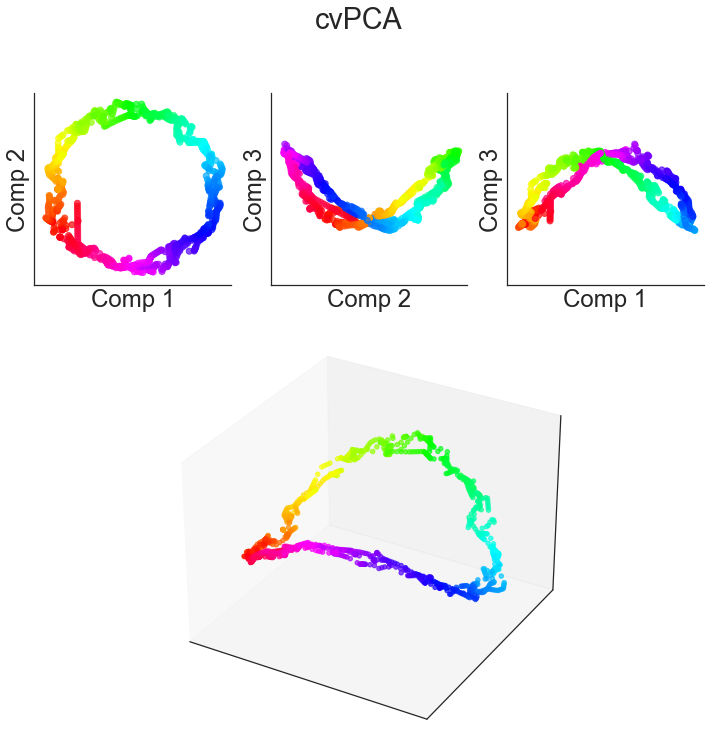

In [351]:
fig = plt.figure(figsize=(12,12))
grid = fig.add_gridspec(ncols=3, nrows=3)
plt.suptitle('cvPCA')
# 3D projectiona
ax = fig.add_subplot(grid[1:,:], projection='3d')
cmap = phi_
scat = ax.scatter(x_embd[:,0], x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
# cbar = plt.colorbar(scat)
# cbar.set_label('Angular position')
# ax.set_xlabel('Comp 1'); ax.set_ylabel('Comp 2'); ax.set_zlabel('Comp 3')
ax.set_xlim([MIN,AXIS_LIM])
ax.set_ylim([MIN,AXIS_LIM])
ax.set_zlim([MIN,AXIS_LIM])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
# ax.set_xticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_xticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_yticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_yticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# ax.set_zticks(np.arange(-AXIS_LIM,AXIS_LIM+.1,.5))
# ax.set_zticklabels([str(-AXIS_LIM),'','0','',str(AXIS_LIM)])
# Comp1 vs Comp2
ax = fig.add_subplot(grid[0,0])
plt.scatter(x_embd[:,0], x_embd[:,1], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 2')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN-.1,AXIS_LIM+.1]); ax.set_ylim([MIN-.1,AXIS_LIM+.1])
sns.despine()
# Comp2 vs Comp3
ax = fig.add_subplot(grid[0,1])
plt.scatter(x_embd[:,1], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 2'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN-.1,AXIS_LIM+.1]); ax.set_ylim([MIN-.1,AXIS_LIM+.1])
sns.despine()
# Comp1 vs Comp3
ax = fig.add_subplot(grid[0,2])
plt.scatter(x_embd[:,0], x_embd[:,2], c=cmap, alpha=.7)
ax.set_xlabel('Comp 1'); plt.ylabel('Comp 3')
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlim([MIN-.1,AXIS_LIM+.1]); ax.set_ylim([MIN-.1,AXIS_LIM+.1])
sns.despine()

# saving
if TYP:
    plt.savefig(figDirReal+'/cvpca_'+LBL+'.svg')
    plt.savefig(figDirReal+'/cvpca_'+LBL+'.png')
else:
    plt.savefig(figDirSim+'/cvpca_'+LBL+'.svg')
    plt.savefig(figDirSim+'/cvpca_'+LBL+'.png')

In [125]:
### OLE  decoding
EMBD = 'cvpca'
N = 3
cv = 10
Y = phi_.flatten() # angulat position
RMSE[EMBD] = np.zeros((N,cv)); R[EMBD] = np.zeros((N,cv))
for n in range(N): # loop over dimensions
    X_ = x_embd[:,:n] # first n dimension of mds embedding
    kf = KFold(n_splits=cv)
    c = 0
    for train_index, test_index in kf.split(X_): # number of cv folds
        # 80% train - 20%  test
        X_train, X_test = X_[train_index], X_[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        f = OLE(X_train, y_train) # f is weight  vector for the dimensions/neurons
        y_pred,rmse,r = LinRec(f,X_test,y_test)
        RMSE[EMBD][n,c] = rmse; R[EMBD][n,c] = r
        c+=1